<a href="https://colab.research.google.com/github/GuptaTanay/Battery-Level-Prediction/blob/main/Battery_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot  as plt
from statsmodels.tsa.stattools import adfuller
# %%matplotlib_inline
from sklearn.metrics import mean_squared_error,mean_absolute_error #, mean_absolute_percentage_error
# accuracy_score,classification_report, confusion_matrix
# from sklearn.metrics 
# import sklearn.metrics.mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

1. Load and understand the data

In [3]:
data = pd.read_excel('BatteryLogs.xlsx')

In [4]:
data.head()

,timestamp,scode,level
0,2021-04-23 07:44:08,3320e01c4f1d6fa898adbeda981150dc,6
1,2021-04-23 07:04:07,ea05a2a12ce40e29289cc6dd9587b665,7
2,2021-04-22 14:56:25,ca1441c0b8503ef6e77620bf602dae49,4
3,2021-04-22 14:47:49,ca1441c0b8503ef6e77620bf602dae49,4
4,2021-04-22 13:51:47,c47b970da888de5b0c0f299ed8a0cda7,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  585 non-null    object
 1   scode      585 non-null    object
 2   level      585 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.8+ KB


In [6]:
data.scode.nunique()

24

In [7]:
data.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
c67cd9070c66fa4ba123d57c545bee28    27
ea05a2a12ce40e29289cc6dd9587b665    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
547b07145a4af0bdcb026af8af3f5b05    14
7ebae810262304e22c8290f106bb9b7d    14
0057f94ed9cf672d1866745ca2324ac7    12
1be7b4ec4330e1fb03e56aa7e81368cb     6
bff3b24e342349f7eda673ee6228aeba     5
e4c48703b9319fd7b9132ff9080c69c3     3
f96ad41c1d11394382264ca085d21945     2
baee826a63b428981915076a9c6cd6a0     2
cf84ad34de243829c53d5b3e83c500f5     2
afd7215063859ee8ff44731986839859     2
58077f6af4a2135bd0c743dfa0b020a8     1
Name: scode, dtype: int64

2. Removing values less than 7

In [8]:
counts = data.scode.value_counts()

res = data[~data.scode.isin(counts[counts < 7].index)]

In [9]:
res.scode.value_counts()

fb706770fada9fb20c6e76ddac98e65c    89
9808db3efa5781dc8862c810efbe1dcd    76
c47b970da888de5b0c0f299ed8a0cda7    51
b7aee4cb26febb88ffa780b5b70474e1    46
271277ca92f8c5142ef4547930402e25    40
9ef6a78a5b766814bc6b153ae6f98f6f    39
b16ba5b277c0e3b5821930ef04b52acc    33
ea05a2a12ce40e29289cc6dd9587b665    27
c67cd9070c66fa4ba123d57c545bee28    27
abbd71e553e9d2b2fe8b4fc4fcec551e    26
ca1441c0b8503ef6e77620bf602dae49    24
96cbc456976f2a1f8193d9dc37502aa7    23
3320e01c4f1d6fa898adbeda981150dc    21
547b07145a4af0bdcb026af8af3f5b05    14
7ebae810262304e22c8290f106bb9b7d    14
0057f94ed9cf672d1866745ca2324ac7    12
Name: scode, dtype: int64

In [10]:
all_sessions = res['scode'].unique()
session_to_id_map = {}
for i in range(len(all_sessions)):
    session_to_id_map[all_sessions[i]] = 'id_' + str(i+1)

res['scode'] = res['scode'].map(session_to_id_map)
res

,timestamp,scode,level
0,2021-04-23 07:44:08,id_1,6
1,2021-04-23 07:04:07,id_2,7
2,2021-04-22 14:56:25,id_3,4
3,2021-04-22 14:47:49,id_3,4
4,2021-04-22 13:51:47,id_4,2
...,...,...,...
580,2020-07-30 07:27:30,id_8,5
581,2020-07-29 20:09:07,id_9,1
582,2020-07-29 19:57:52,id_9,2
583,2020-07-29 19:46:33,id_9,3


In [11]:
res[['scode','level']].groupby(['level']).describe()

scode                   
      count unique    top freq
level                         
0         3      2   id_4    2
1        20      8   id_9    6
2        73      9   id_4   39
3        76     11   id_9   20
4        90     13  id_14   14
5       120     15  id_14   21
6       137     12  id_14   44
7        43     11   id_2   14

3.  Sorting based on timestamp column

In [12]:
final_data = pd.DataFrame()

unique_scodes = res['scode'].unique()
for scode in unique_scodes:
    data_for_scode = res[ res['scode'] == scode ]
    data_for_scode = data_for_scode.sort_values(by='timestamp')
    final_data = final_data.append(data_for_scode)

final_data.groupby(['scode']).describe()

level                                               
      count      mean       std  min   25%  50%   75%  max
scode                                                     
id_1   21.0  4.571429  1.247855  1.0  4.00  5.0  5.00  7.0
id_10  14.0  5.642857  0.633324  5.0  5.00  6.0  6.00  7.0
id_11  33.0  3.757576  1.346994  1.0  3.00  4.0  5.00  7.0
id_12  23.0  3.478261  1.274561  1.0  3.00  3.0  4.50  6.0
id_13  27.0  2.888889  1.281025  1.0  2.00  3.0  3.50  7.0
id_14  89.0  5.561798  0.891310  4.0  5.00  6.0  6.00  7.0
id_15  12.0  3.666667  1.370689  1.0  2.75  4.0  5.00  5.0
id_16  14.0  5.642857  1.150728  3.0  5.00  5.5  6.75  7.0
id_2   27.0  6.259259  0.944319  4.0  6.00  7.0  7.00  7.0
id_3   24.0  4.291667  1.428869  0.0  3.75  4.0  5.00  7.0
id_4   51.0  2.078431  1.055332  0.0  2.00  2.0  2.00  6.0
id_5   40.0  4.825000  1.009887  2.0  4.00  5.0  6.00  6.0
id_6   76.0  4.828947  1.454997  2.0  4.00  5.0  6.00  7.0
id_7   26.0  5.884615  0.765607  4.0  5.25  6.0  6.00  7.0
id_8   46.0  4.543478  1.241979  1.0  4.00  5.0  5.00  7.0
id_9   39.0  2.615385  0.906566  1.0  2.00  3.0  3.00  4.0

In [13]:
final_data.dtypes

timestamp    object
scode        object
level         int64
dtype: object

4.Moving timestamp to index column

In [14]:
final_data['timestamp']=pd.to_datetime(final_data['timestamp'])

In [15]:
final_data.dtypes

timestamp    datetime64[ns]
scode                object
level                 int64
dtype: object

In [16]:
final_data.set_index('timestamp',inplace=True)

In [17]:
final_data.head(20)

,scode,level
timestamp,,
2020-08-05 08:26:09,id_1,1
2020-09-02 10:54:22,id_1,4
2020-09-07 18:45:19,id_1,5
2020-09-08 17:34:04,id_1,5
2020-09-09 17:32:42,id_1,5
2020-09-17 09:27:40,id_1,5
2020-09-21 09:28:17,id_1,5
2020-09-22 11:49:22,id_1,4
2020-09-22 12:49:37,id_1,2


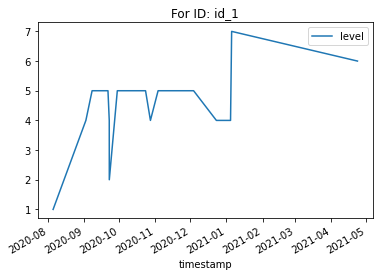

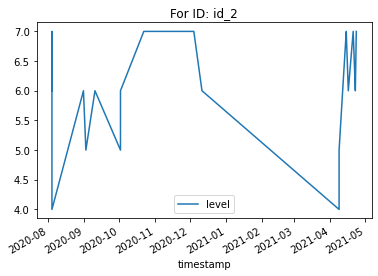

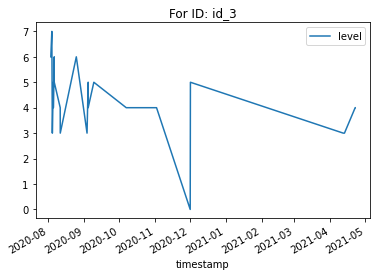

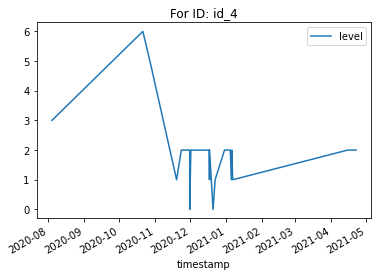

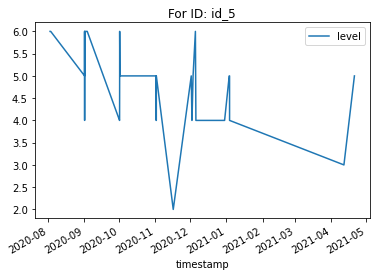

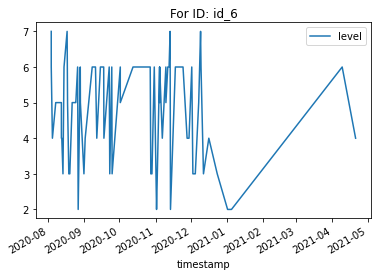

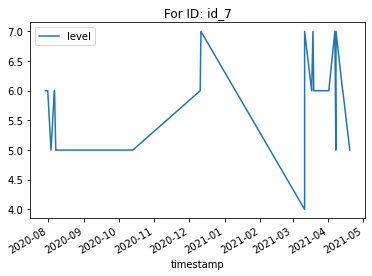

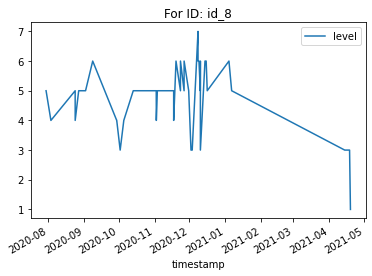

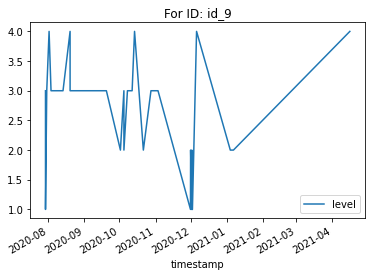

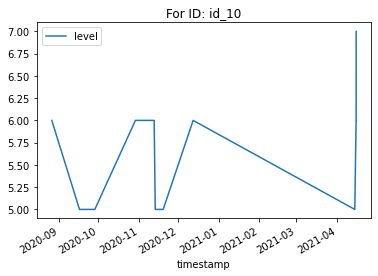

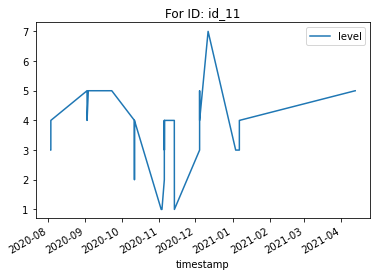

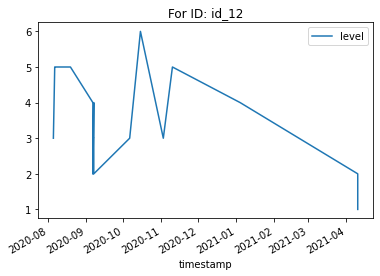

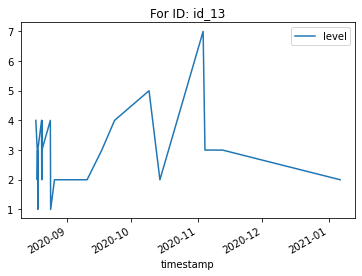

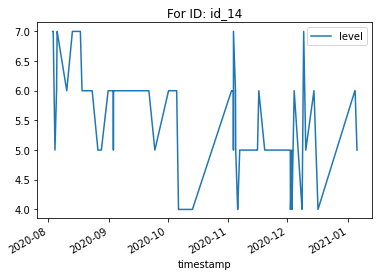

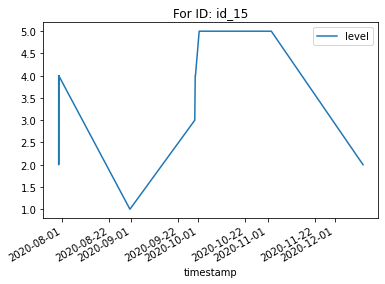

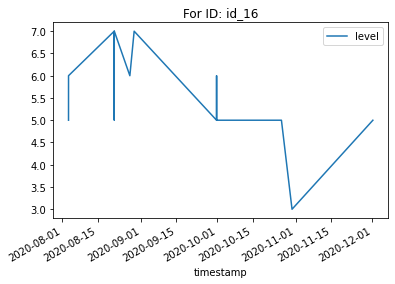

In [18]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    data_for_scode.plot(title = 'For ID: '+ str(scode))

In [19]:
#Ho: It is non stationary
#H1: It is stationary
non_stationary = []
def adfuller_test(df, scode, add_to_non = False):
    result=adfuller(df)
    if result[1] > 0.05:
        print("Time series is non-stationary for: "+ scode)
        if add_to_non:
          non_stationary.append(scode)

In [20]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    adfuller_test(data_for_scode['level'], scode, True)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_9
Time series is non-stationary for: id_10
Time series is non-stationary for: id_12
Time series is non-stationary for: id_13
Time series is non-stationary for: id_15
Time series is non-stationary for: id_16


In [21]:
# non_stationary
non_stationary = np.array(non_stationary, dtype='O')

In [22]:
for i in non_stationary:
  data_for_scode = final_data[ final_data['scode'] == i ]
  # data_for_scode.plot(title = 'For ID: '+ str(i))
  data_for_scode['Seasonal First Difference']=data_for_scode['level']-data_for_scode['level'].shift(14)
  adfuller_test(data_for_scode['level'], i)

Time series is non-stationary for: id_3
Time series is non-stationary for: id_9
Time series is non-stationary for: id_10
Time series is non-stationary for: id_12
Time series is non-stationary for: id_13
Time series is non-stationary for: id_15
Time series is non-stationary for: id_16


                            id_1


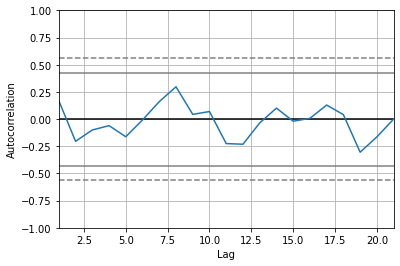

                            id_2


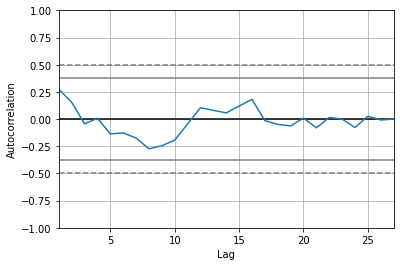

                            id_3


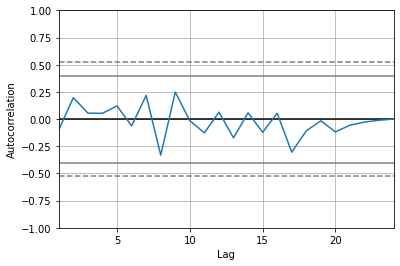

                            id_4


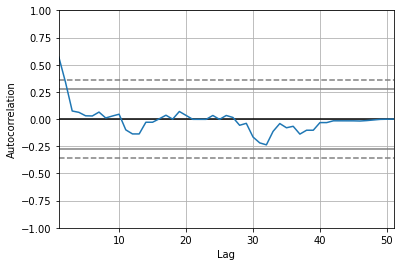

                            id_5


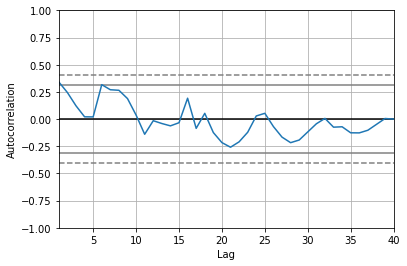

                            id_6


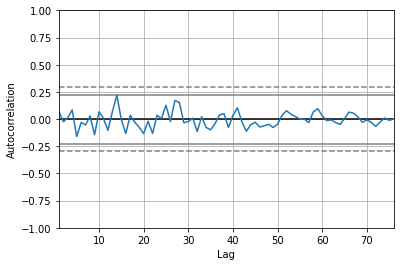

                            id_7


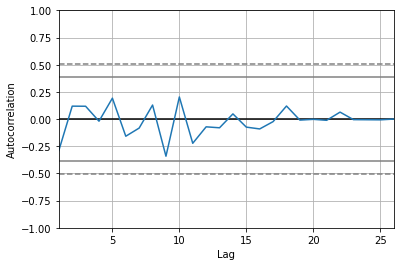

                            id_8


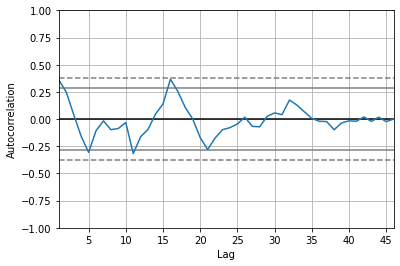

                            id_9


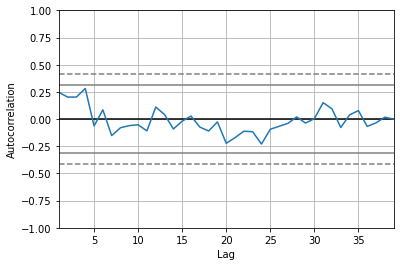

                            id_10


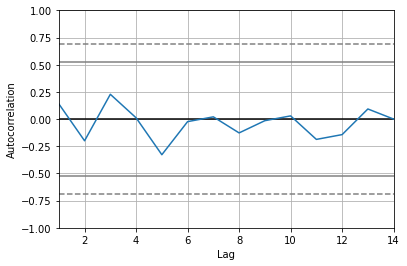

                            id_11


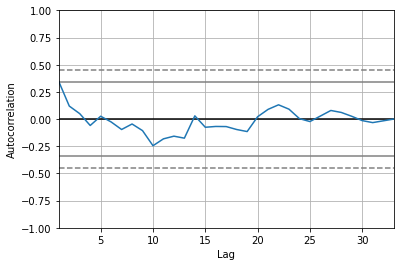

                            id_12


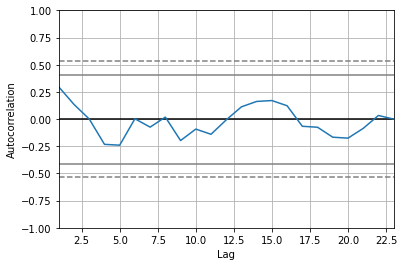

                            id_13


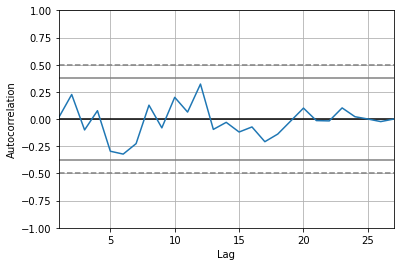

                            id_14


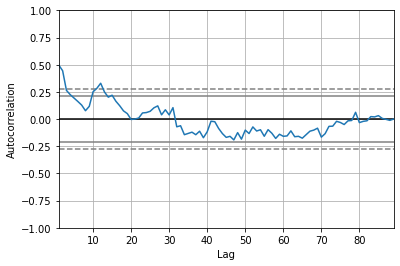

                            id_15


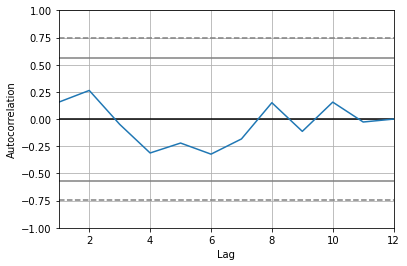

                            id_16


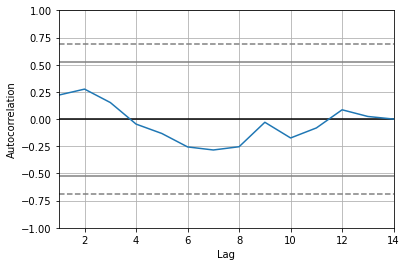

In [23]:
#  selecting p value for each id
from pandas.plotting import autocorrelation_plot
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    print('                            '+scode)
    autocorrelation_plot(data_for_scode['level'])
    plt.show()  

In [24]:
p_value = {'id_1': 0,
           'id_2': 0,
           'id_3': 0,
           'id_4': 1,
           'id_5': 1,
           'id_6': 0,
           'id_7': 1,
           'id_8': 0,
           'id_9': 0,
           'id_10': 0,
           'id_11': 0 ,
           'id_12': 0,
           'id_13': 0,
           'id_14': 2,
           'id_15': 0,
           'id_16': 0}

In [25]:
# final_data
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# acf for p value of each id
# pacf for q value of each id

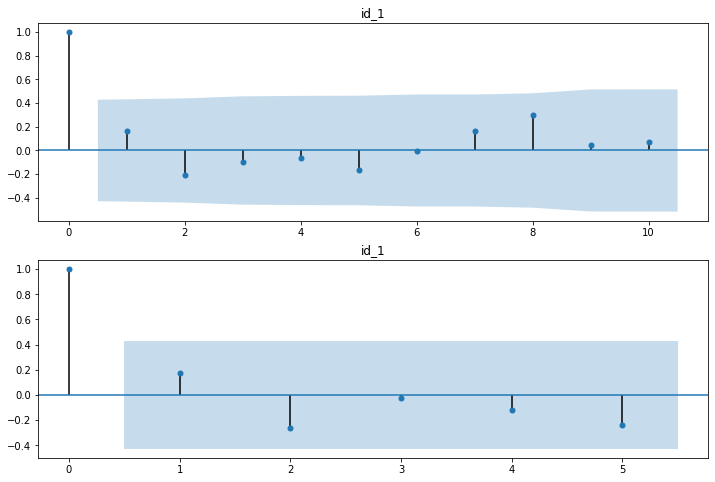

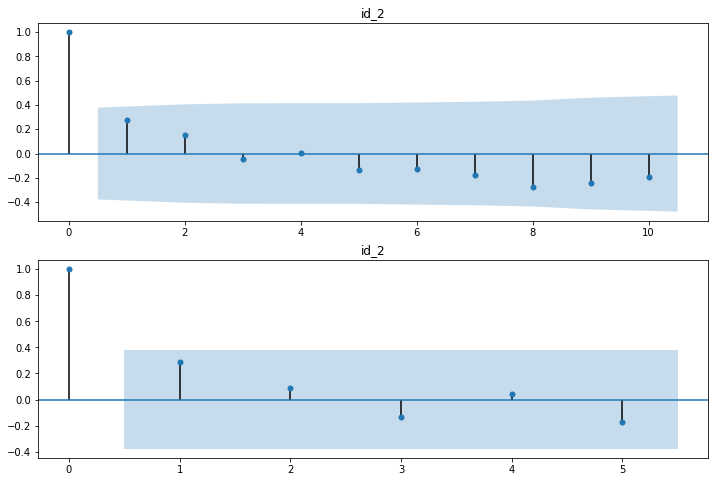

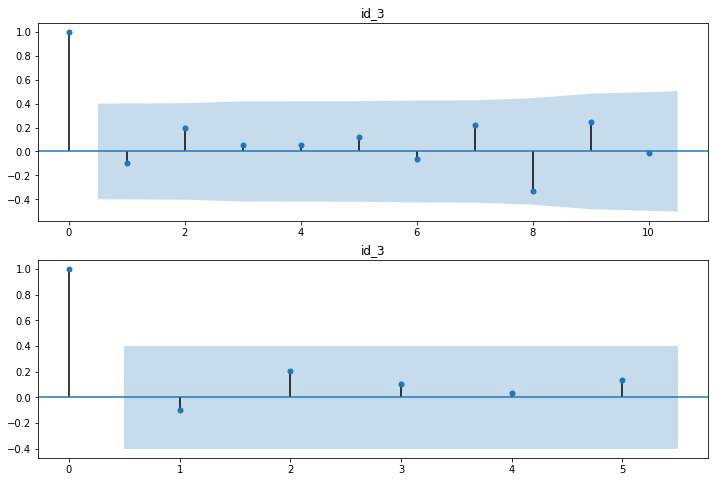

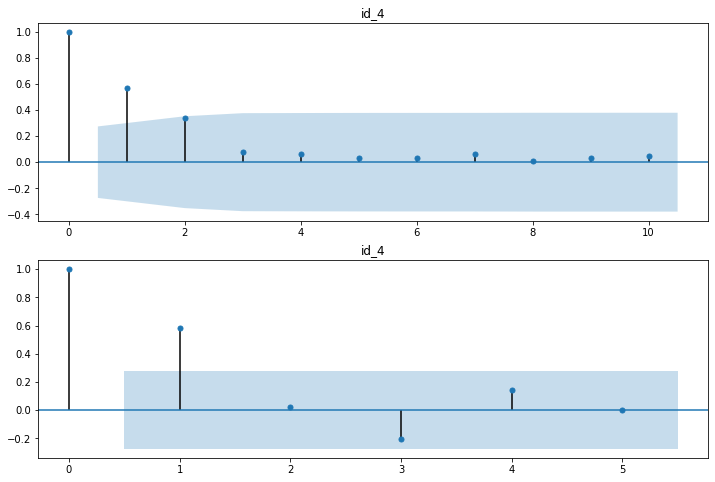

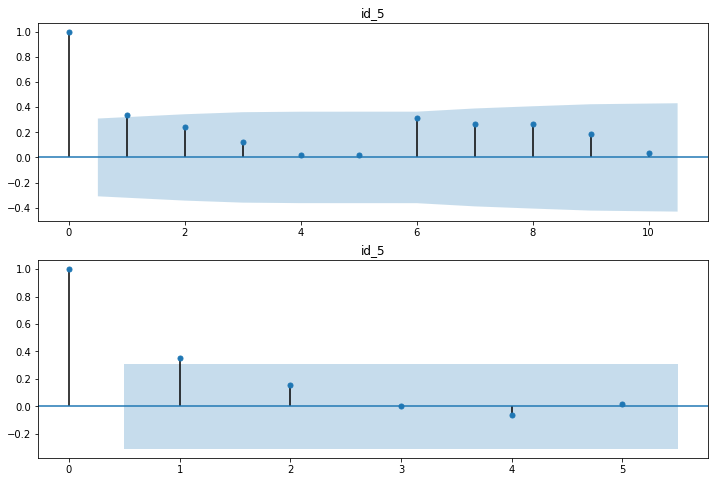

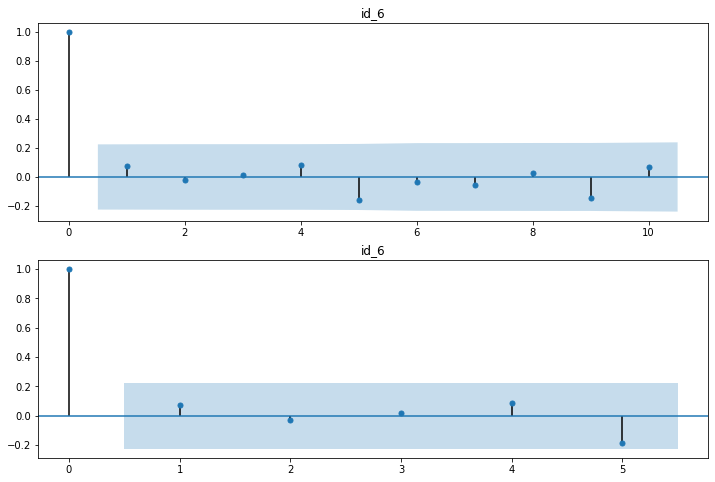

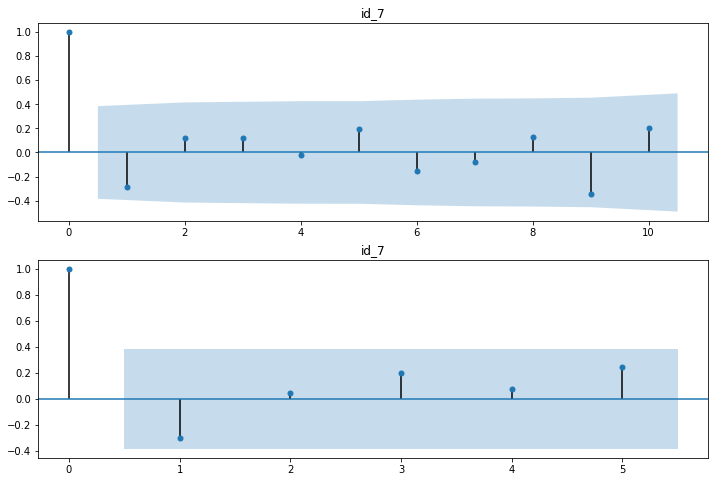

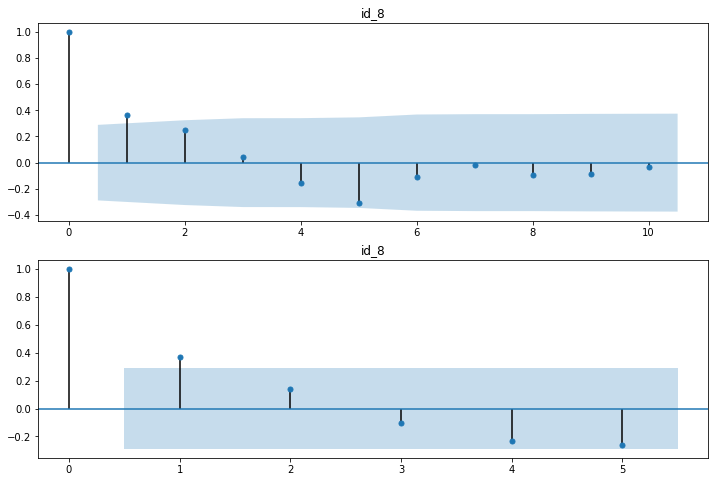

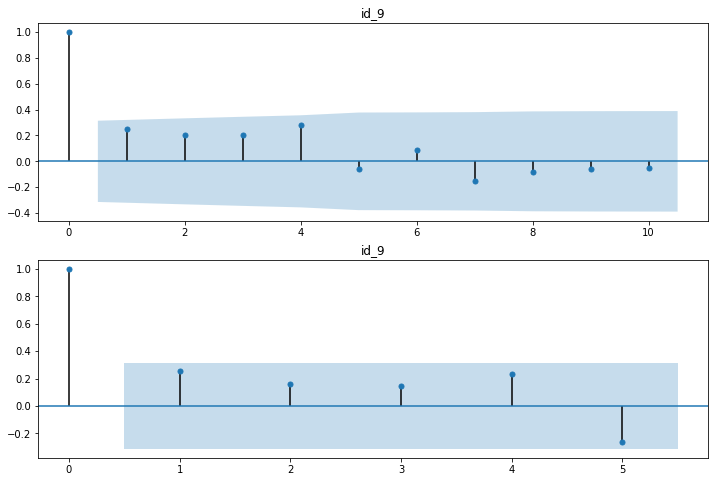

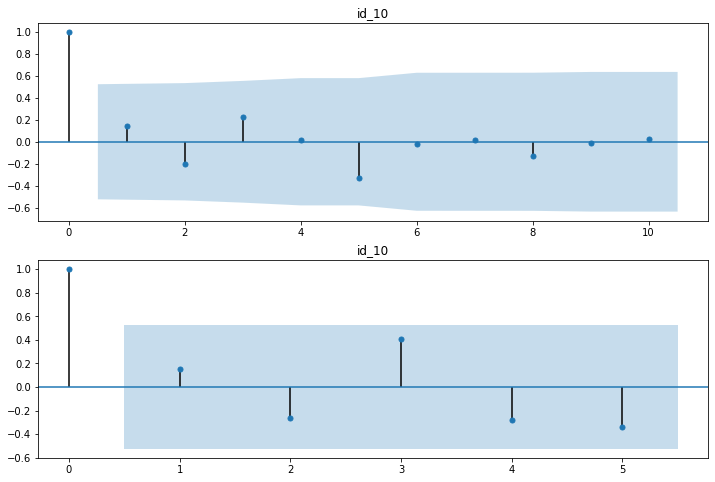

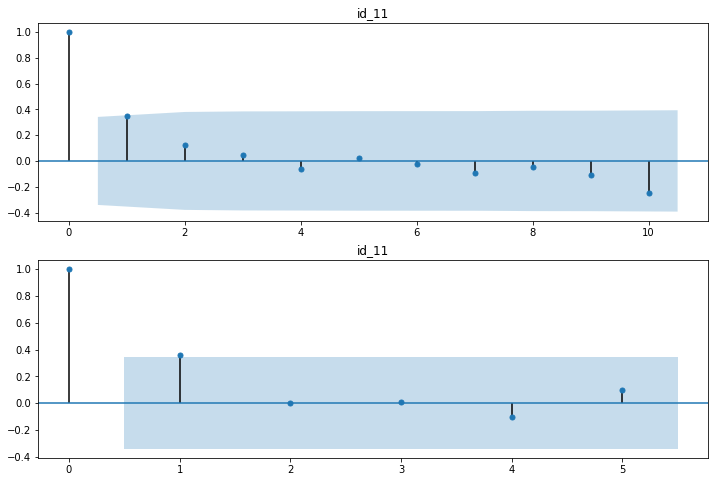

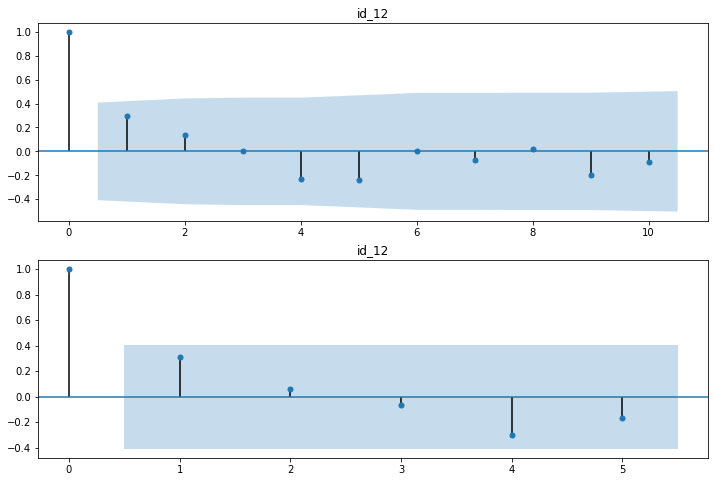

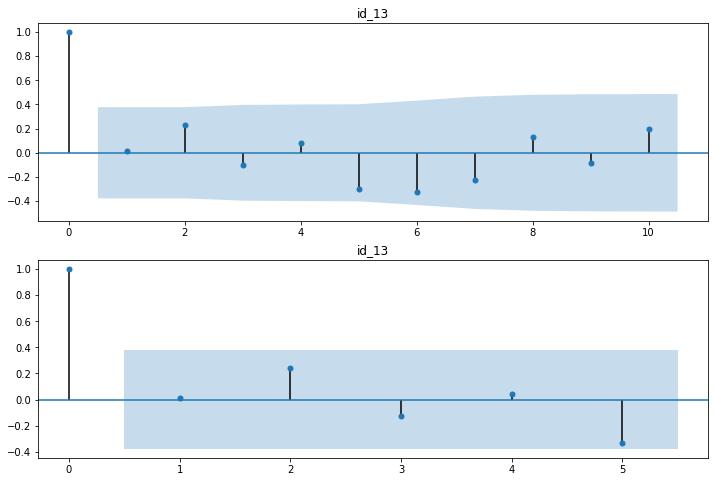

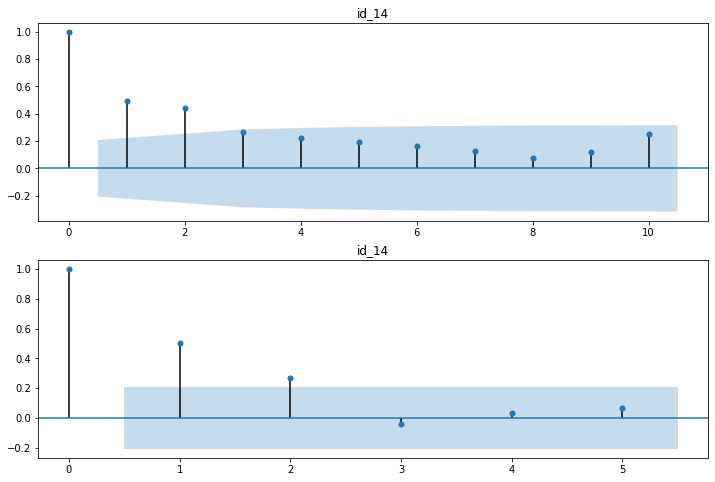

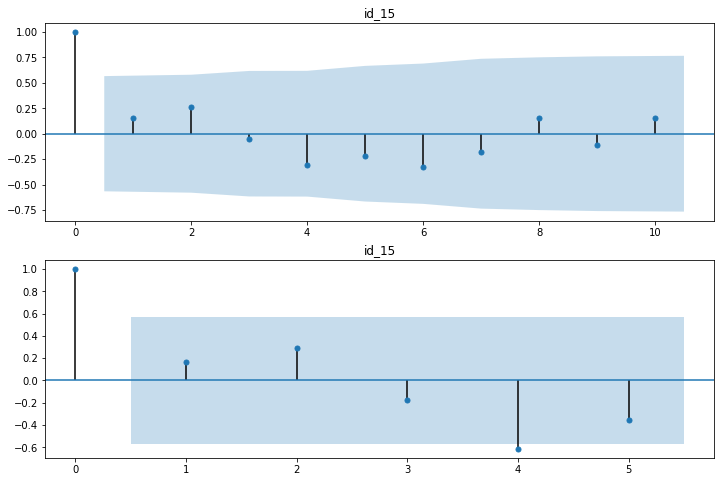

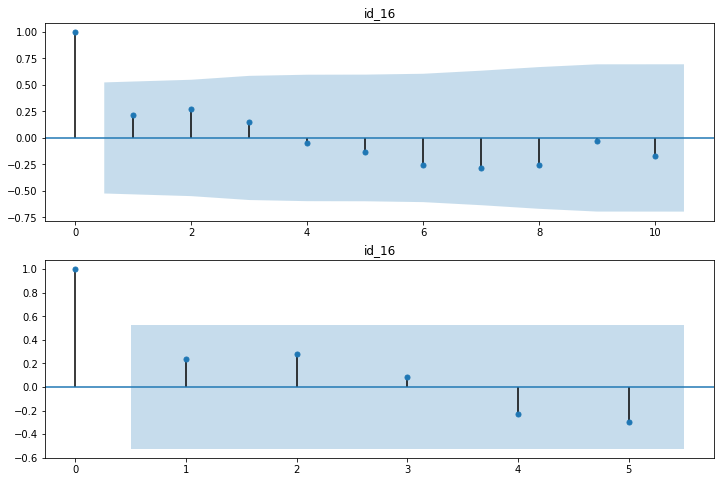

In [26]:
for scode in unique_scodes:
    data_for_scode = final_data[ final_data['scode'] == scode ]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data_for_scode['level'],lags=10,ax=ax1, title =scode)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data_for_scode['level'],lags=5,ax=ax2, title =scode)

In [27]:
q = 1

In [28]:
def calculate_error(rmse, mae):
  mean_rmse  = sum(rmse)/ len(rmse)
  mean_mae = sum(mae)/ len(mae)
  return mean_rmse, mean_mae

In [31]:
def calculate_ARIMA():  
  arima_rmse, arima_mae = [], []
  for scode in unique_scodes:
      data_for_scode = final_data[ final_data['scode'] == scode ]
      data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
      if scode in non_stationary or scode in ['id_6']:
        continue

      model=ARIMA(data_for_scode['level'].astype(float) ,order=(0,0,0))
      model_fit=model.fit()
      data_for_scode['ARIMA_Forecast'] = model_fit.predict(start = 0, end= len(data_for_scode) +4 , dynamic = True)
      data_for_scode[['level','ARIMA_Forecast']].plot(figsize=(12,8))
      # testScore = accuracy_score(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      RMSE = mean_squared_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
      arima_rmse.append(RMSE)
      MAE = mean_absolute_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      print('MAE for '+ str(scode) + ' is: ' + str(MAE))
      arima_mae.append(MAE)
      # MAPE = mean_absolute_percentage_error(data_for_scode['level'], data_for_scode['ARIMA_Forecast'])
      # print('MAE for '+ str(scode) + ' is: ' + str(MAPE))
  print('-----------------------------------------')
  mean_mse, mean_mae = calculate_error(arima_rmse, arima_mae)
  print('Mean RMSE is:'+ str(mean_mse))
  print('Mean MAE is: '+ str(mean_mae))
      # print('--------------------------------')
      # print('Model Summary for : ' +scode)
      # print(model_fit.summary())

RMSE for id_1 is: 1.4829931972789112
MAE for id_1 is: 0.8571428571428579
RMSE for id_2 is: 0.858710562414266
MAE for id_2 is: 0.7681755829903978
RMSE for id_4 is: 1.0918877354863514
MAE for id_4 is: 0.4944252210688195
RMSE for id_5 is: 0.994375
MAE for id_5 is: 0.8187500009604468
RMSE for id_7 is: 0.5636094674556215
MAE for id_7 is: 0.5532544403983638
RMSE for id_8 is: 1.5089792060491494
MAE for id_8 is: 1.0378071833648392
RMSE for id_11 is: 1.7594123048668504
MAE for id_11 is: 1.035812672176309
RMSE for id_14 is: 0.7855068804443882
MAE for id_14 is: 0.7564701426587558
-----------------------------------------
Mean RMSE is:1.1306842942494422
Mean MAE is: 0.7902297625950988


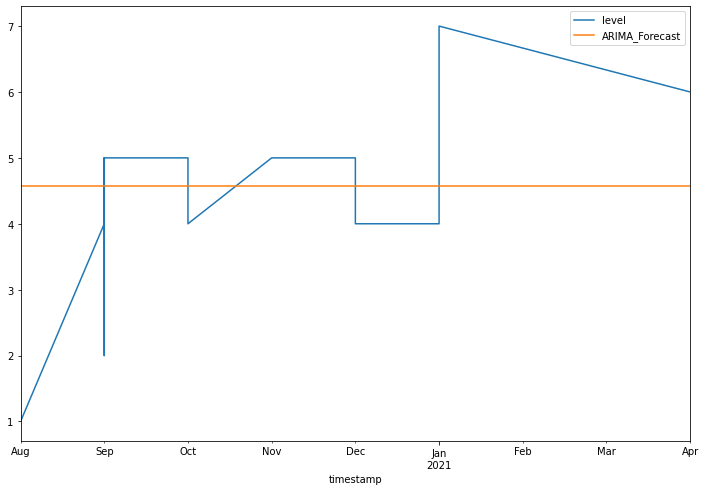

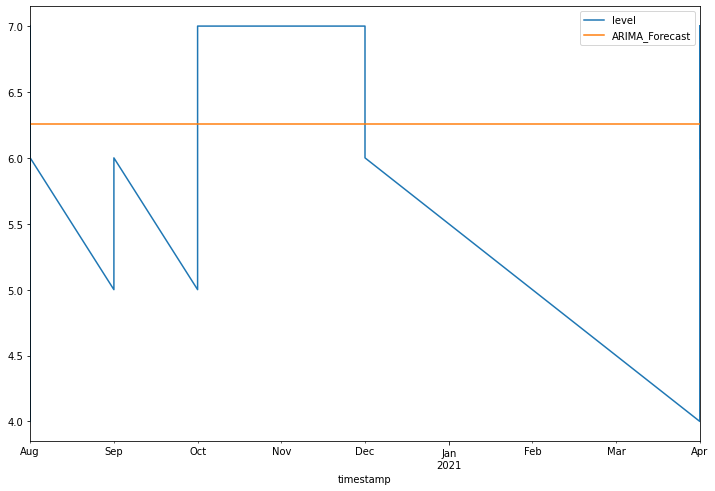

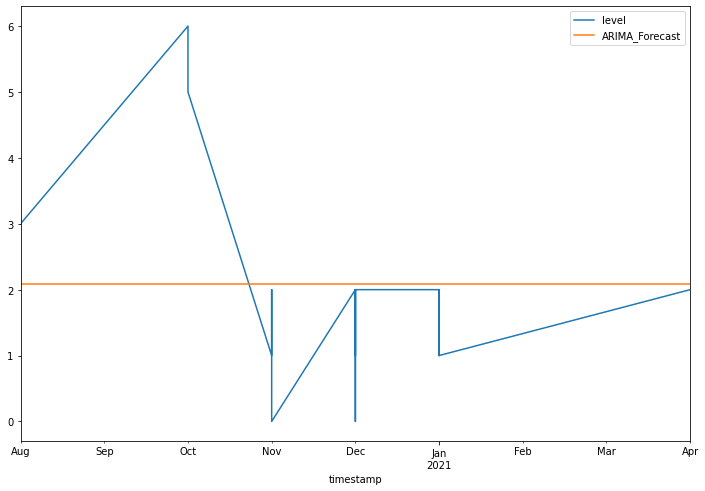

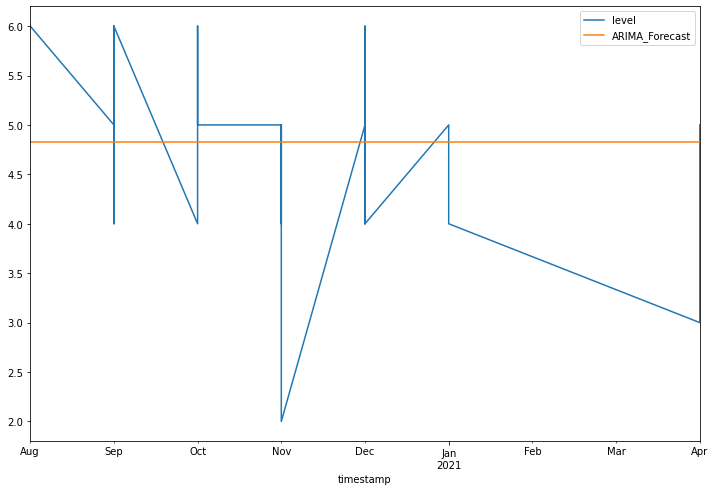

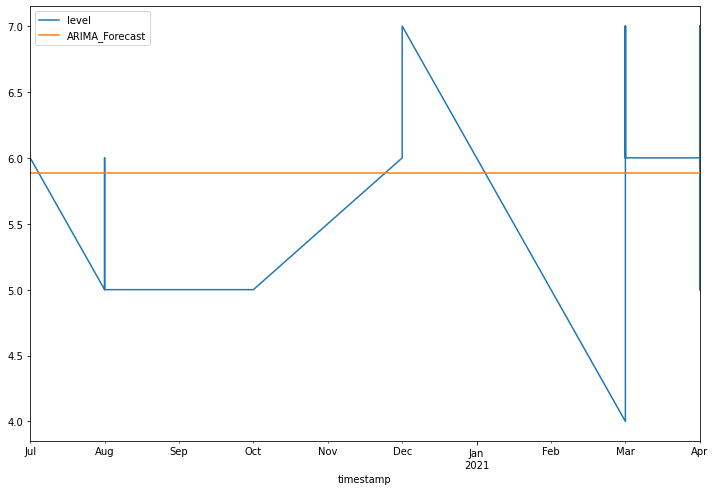

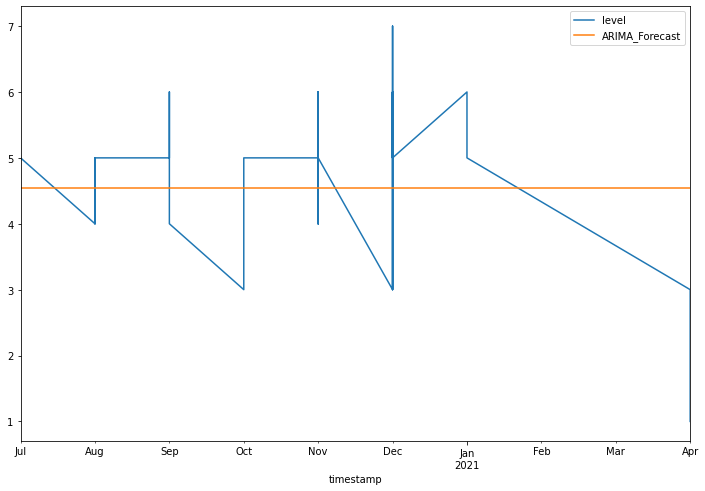

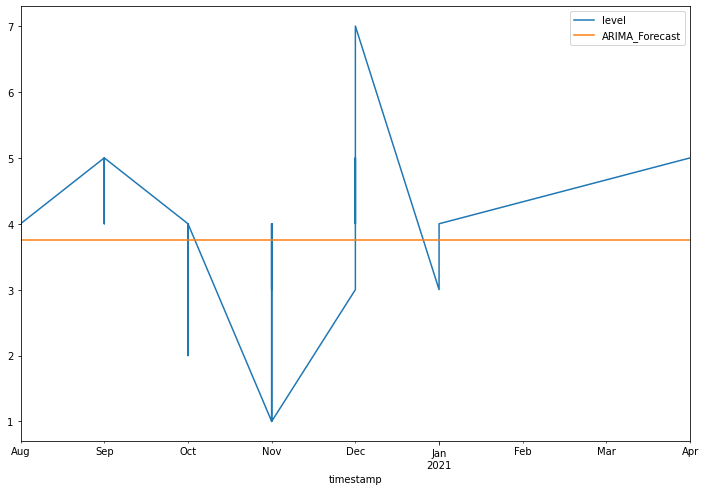

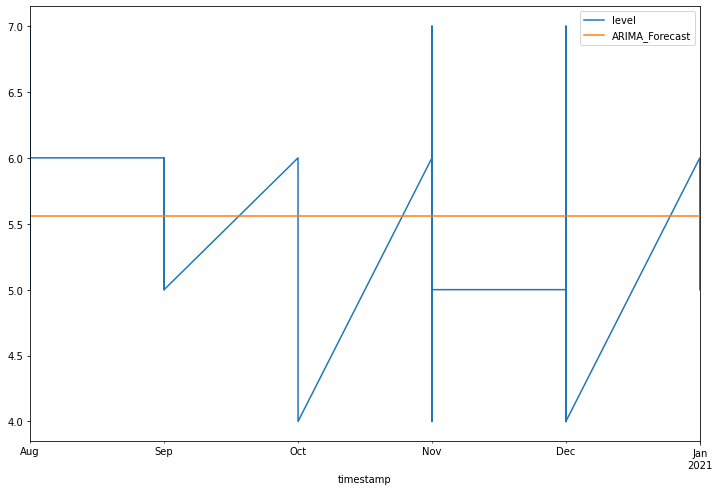

In [32]:
calculate_ARIMA()

In [37]:
# !pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg

In [56]:
def calculate_AR():  
  ar_rmse, ar_mae = [], []
  for scode in unique_scodes:
      data_for_scode = final_data[ final_data['scode'] == scode ]
      data_for_scode.index = pd.DatetimeIndex(data_for_scode.index).to_period('M')
      # if scode in non_stationary or scode in ['id_6']:
      #   continue

      model= AutoReg(data_for_scode['level'], lags=1)
      # MA(data_for_scode['level'].astype(float) ,order=(0,0,0))
      model_fit=model.fit()
      data_for_scode['AR_Forecast'] = model_fit.predict(start = 0, end= len(data_for_scode) +4 , dynamic = True)
      data_for_scode[['level','AR_Forecast']].plot(figsize=(12,8))
      data_for_scode['AR_Forecast'] = data_for_scode['AR_Forecast'].fillna(0)
      RMSE = mean_squared_error(data_for_scode['level'], data_for_scode['AR_Forecast'])
      print('RMSE for '+ str(scode) + ' is: ' + str(RMSE))
      ar_rmse.append(RMSE)
      MAE = mean_absolute_error(data_for_scode['level'], data_for_scode['AR_Forecast'])
      print('MAE for '+ str(scode) + ' is: ' + str(MAE))
      ar_mae.append(MAE)
      
  print('-----------------------------------------')
  mean_mse, mean_mae = calculate_error(ar_rmse, ar_mae)
  print('Mean RMSE is:'+ str(mean_mse))
  print('Mean MAE is: '+ str(mean_mae))
      # print('--------------------------------')
      # print('Model Summary for : ' +scode)
      # print(model_fit.summary())

RMSE for id_1 is: 0.898568808270814
MAE for id_1 is: 0.7683704295257033
RMSE for id_2 is: 5.707401693406319
MAE for id_2 is: 1.481795366902926
RMSE for id_3 is: 12.810953778688024
MAE for id_3 is: 2.7629740416410864
RMSE for id_4 is: 1.3410630941875799
MAE for id_4 is: 0.6088192932540304
RMSE for id_5 is: 4.355838883128152
MAE for id_5 is: 1.2525323483357718
RMSE for id_6 is: 8.206792081404744
MAE for id_6 is: 2.2598207685093135
RMSE for id_7 is: 4.709718938292687
MAE for id_7 is: 1.2291945680827472
RMSE for id_8 is: 2.049353469058104
MAE for id_8 is: 1.144788705337146
RMSE for id_9 is: 1.2764117017675007
MAE for id_9 is: 0.8744583981102986
RMSE for id_10 is: 2.949089546718935
MAE for id_10 is: 0.9646850733349562
RMSE for id_11 is: 2.8677047790597268
MAE for id_11 is: 1.3310673672555942
RMSE for id_12 is: 5.82300679992093
MAE for id_12 is: 1.7345017282982593
RMSE for id_13 is: 5.849372580013081
MAE for id_13 is: 2.0434901952293503
RMSE for id_14 is: 8.730364116588223
MAE for id_14 is: 

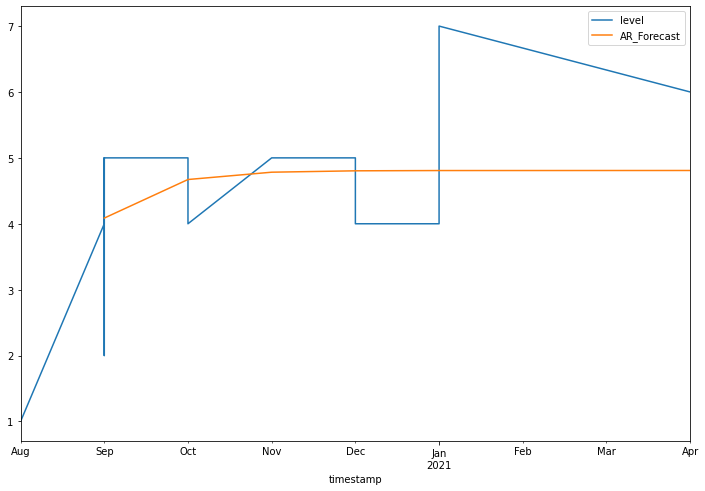

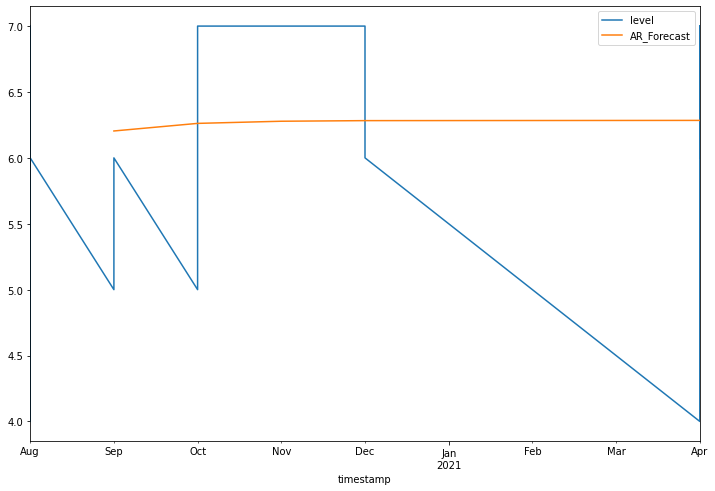

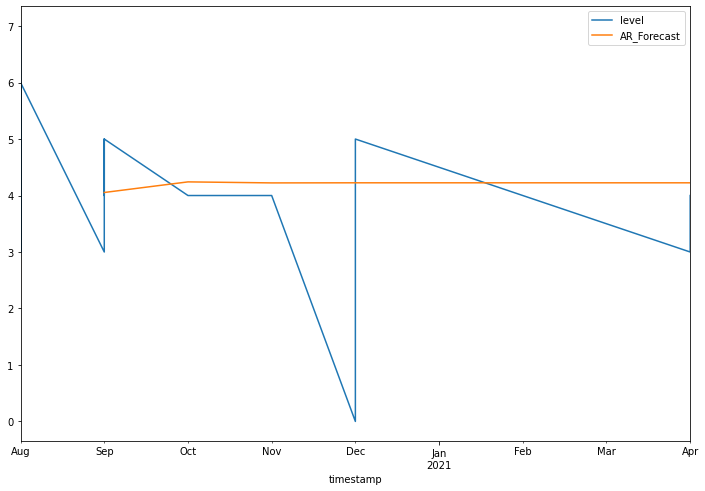

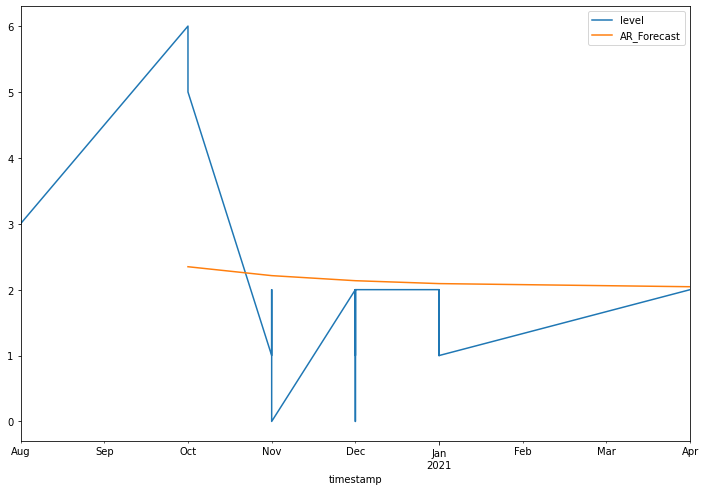

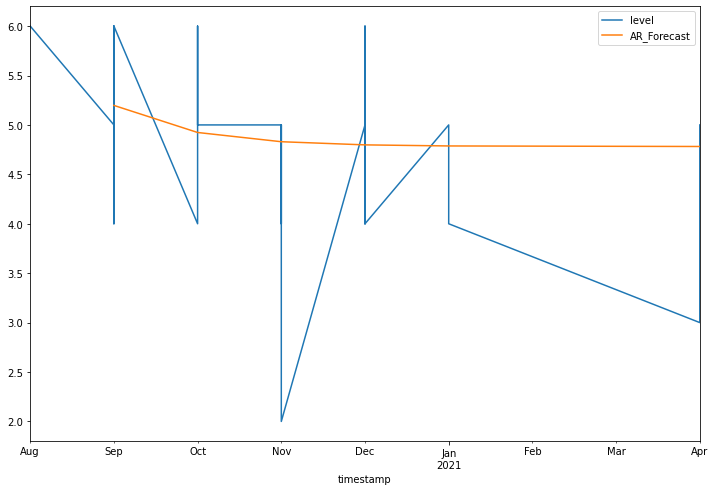

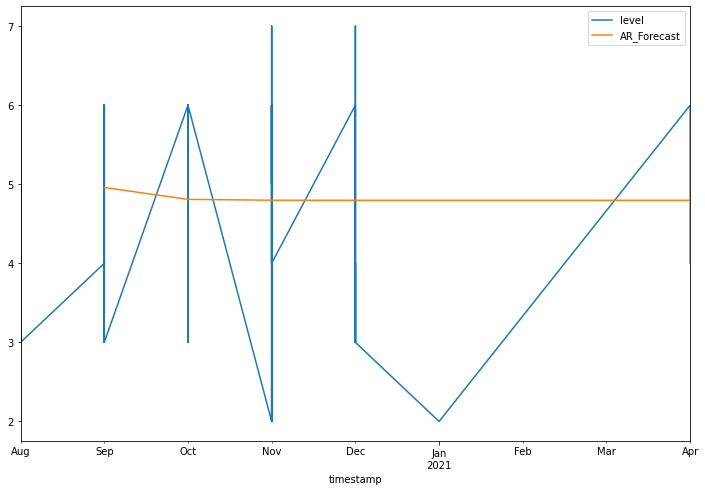

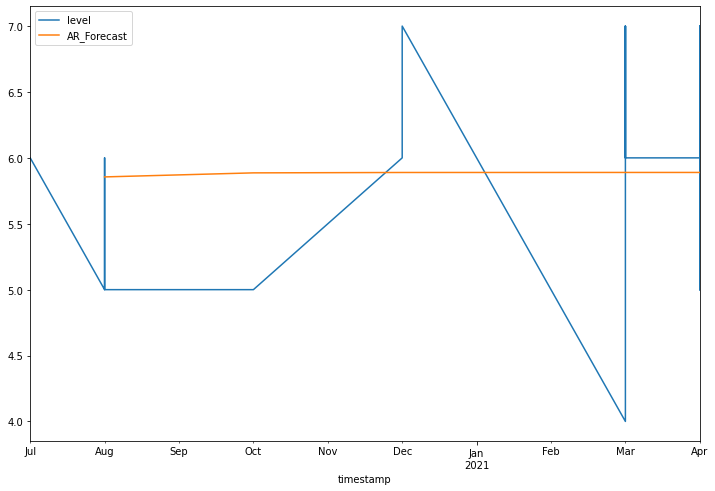

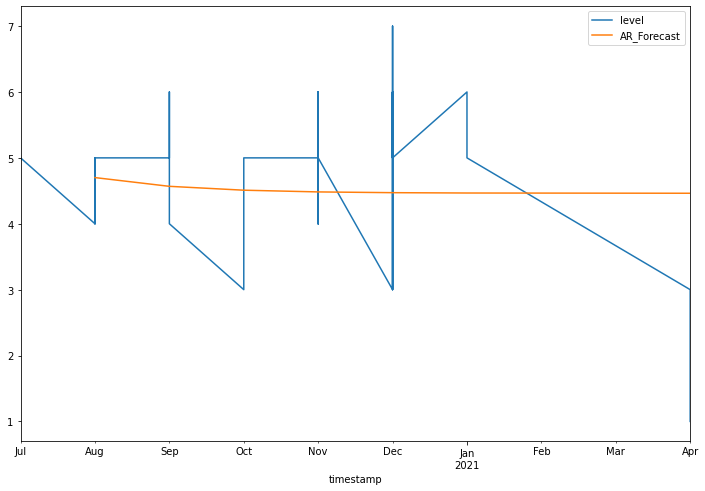

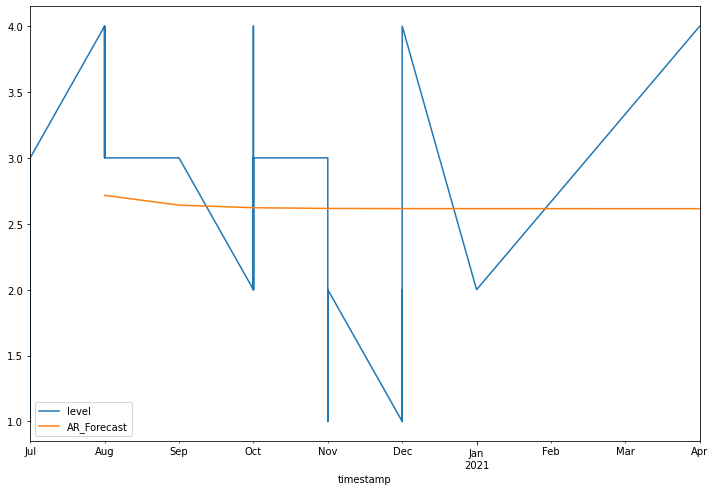

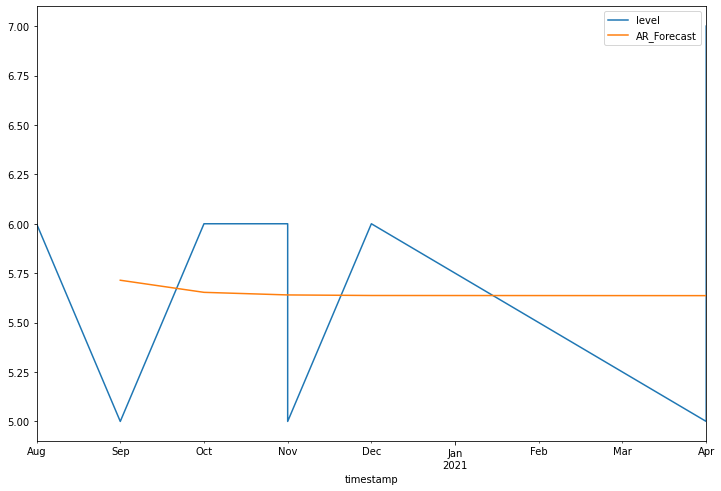

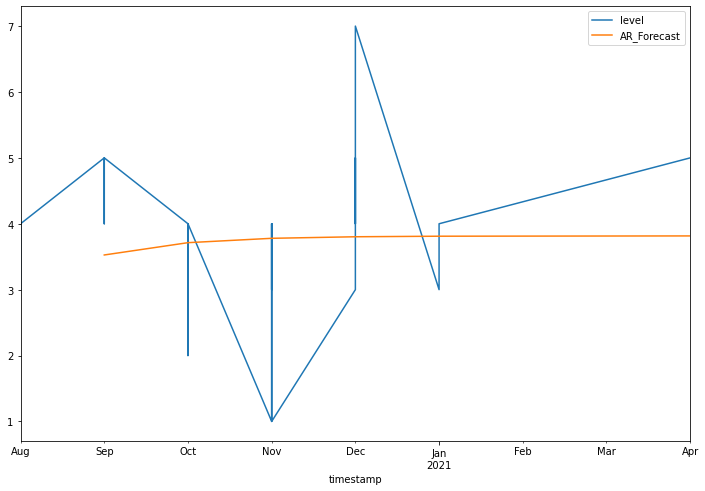

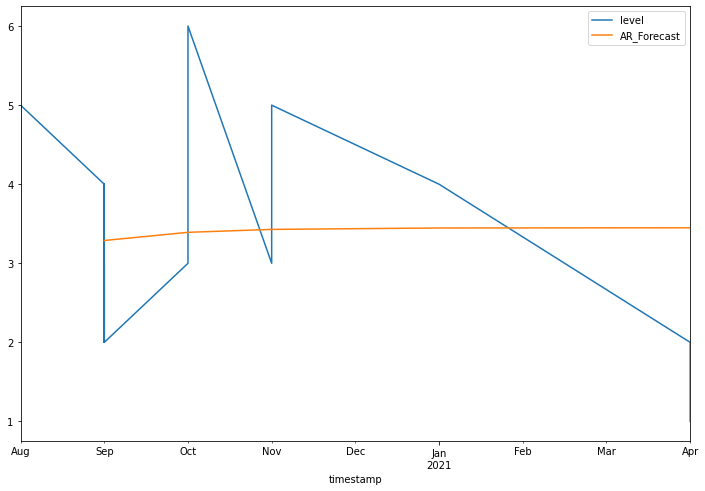

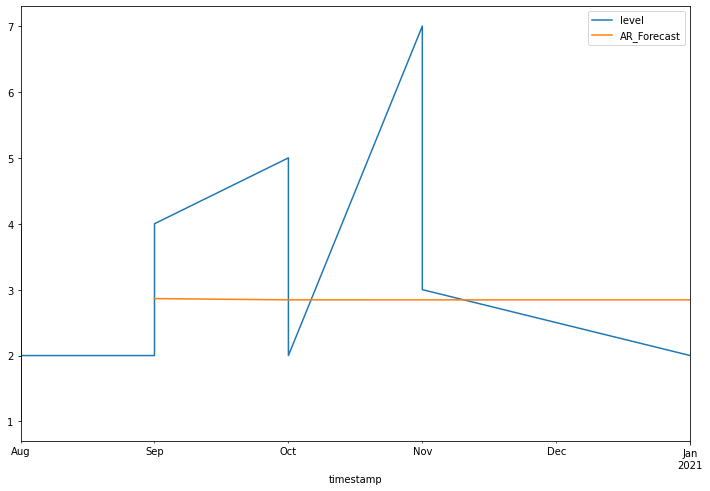

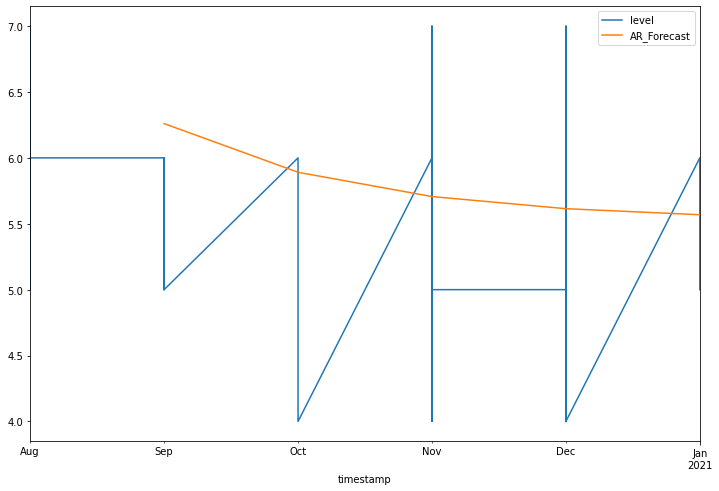

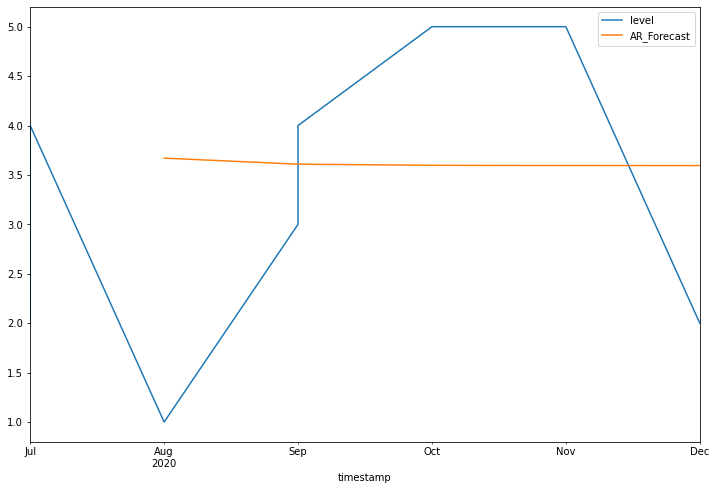

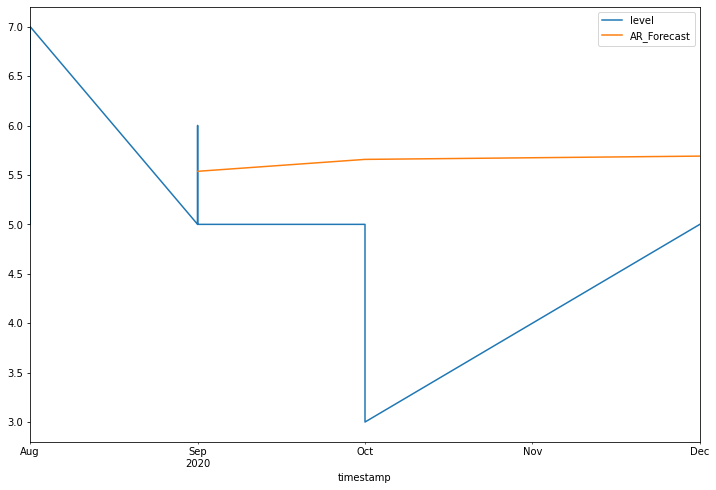

In [57]:
calculate_AR()